In [1]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np
import copy

import partitioning

In [3]:
# Load encodings
file_path = 'datasets/encoding_data/encodings_celebA_1000.pickle'
raw_data = pickle.loads(open(file_path, "rb").read())
data = [list(d['encoding']) for d in raw_data]

[Note] For k-member clustering, this algorithm is highly in-efficent. Especially for around 1000 datapoints and k=20, it requires around 350 seconds to complete. For more details on each iteration, enable: verbose=True. This is NOT an implementation issue, it is the disadvantage of greedy-type algorithm. The main reason is that the 'find_best_record' function (please see original paper [1] for mode details) loops for the whole remaining data to find a best record. For example, some of the first rounds, the number of remaining data is apporiximately the size of whole dataset.

[1] Byun, J.W., Kamra, A., Bertino, E. and Li, N., 2007, April. Efficient k-anonymization using clustering techniques. In International Conference on Database Systems for Advanced Applications (pp. 188-200). Springer, Berlin, Heidelberg.

In [ ]:
#k-member clustering
input_data = copy.deepcopy(data)

clusters_kmember = partitioning.kmember_partition(input_data, 20, verbose=False)

#OKA 
input_data = copy.deepcopy(data)
clusters_oka = partitioning.oka_partition(input_data, 20)

In [7]:
# Convert result type
labels_kmember = partitioning.cluster_member_to_index(clusters_kmember, data)
labels_oka = partitioning.cluster_member_to_index(clusters_oka, data)


# Calculate statistics
df_kmember = partitioning.cluster_stats(data, labels_kmember)
df_oka = partitioning.cluster_stats(data, labels_oka)

# Update labels
df_kmember['strategy'] = 'knn variance'
df_kmember['method'] = 'kmember'

df_oka['strategy'] = 'k-means variance'
df_oka['method'] = 'OTP'


# Combine results
df_related = df_kmember.append(df_oka, ignore_index = True)
list(df_related.columns.values)

# Rename the columns
df_related.columns = ['label', 'size', 'min dist', 'max dist', 'mean dist', 'mean silhouette', 'strategy', 'method']
df_related

# Re-order the column 
df_related_ordered = df_related[ ['label', 'max dist', 'min dist', 'mean dist', 'size', 'mean silhouette', 'method', 'strategy'] ]

#Calculate the mean silhouette based for the whole method
df_related_ordered.loc[df_related_ordered.method == 'kmember', 'mean silhouette'] = df_related_ordered.loc[df_related_ordered.method == 'kmember', 'mean silhouette'].mean()
df_related_ordered.loc[df_related_ordered.method == 'OTP', 'mean silhouette'] = df_related_ordered.loc[df_related_ordered.method == 'OTP', 'mean silhouette'].mean()


In [ ]:
# Load other results
df = pd.read_csv('outputs/dlib_clt.csv')
# Rename columns
df.columns = ['label', 'max dist', 'min dist', 'mean dist', 'size', 'mean.cl.sil', 'mean silhouette', 'method', 'strategy']
# Select important columns
df_selected = df[ ['label', 'max dist', 'min dist', 'mean dist', 'size', 'mean silhouette', 'method', 'strategy'] ]


# Selecting and correct some names

df_hier_strategy = df_selected[df_selected.strategy == 'Hierarchical partition']
# Select only three methods
df_hier_strategy_methods = df_hier_strategy.loc[df_hier_strategy['method'].isin(['average', 'complete', 'ward.D'])]
df_hier_strategy_methods.strategy = 'hierarchical partition' # rename
df_hier_strategy_methods.loc[df_hier_strategy_methods.method == 'ward.D', 'method'] = 'ward' # rename

df_knn_strategy = df_selected[df_selected.strategy == 'Nearest Neighbors']
# Select two methods
df_knn_strategy_methods = df_knn_strategy.loc[df_knn_strategy['method'].isin(['random', 'maxd'])]
df_knn_strategy_methods.strategy = 'knn variance' # rename
df_knn_strategy_methods.loc[df_knn_strategy_methods.method == 'random', 'method'] = 'k-same' # rename
df_knn_strategy_methods.loc[df_knn_strategy_methods.method == 'maxd', 'method'] = 'max dist' # rename

df_elki = df_selected[df_selected.strategy == 'Kmeans partition']
# Select two methods
df_elki = df_elki.loc[df_elki['method'].isin(['elki', 'random'])]
df_elki.strategy = 'k-means variance' # rename


In [9]:
# Concat all the results above
df_final = pd.concat([df_hier_strategy_methods, df_elki, df_knn_strategy_methods, df_related_ordered], ignore_index=True, sort =False)

# Select only 4 columns for the figures
df_extract = df_final[['max dist', 'min dist', 'mean dist', 'method','strategy']]


In [13]:
# Save this result
df_final.to_pickle('outputs/df_final.pickle')
df_extract.to_pickle('outputs/df_extract.pickle')

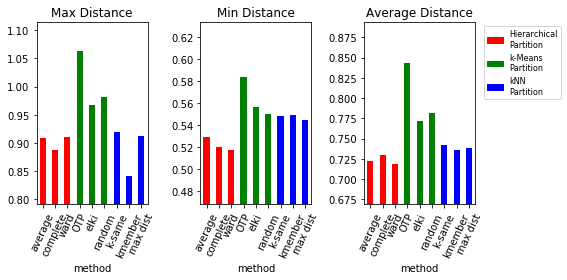

In [10]:
# Draw the bar-graph
# import matplotlib.patches as mpatches
dist_stats = df_extract.groupby(['strategy', 'method']).mean()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8,4), sharey=False)
plt.style.use('default')
colors = {'hierarchical partition': 'r', 'k-means variance': 'g','knn variance': 'b' }
titles = ['Max Distance', 'Min Distance','Average Distance']
for key, ax, title in zip(list(dist_stats), axes.flatten(), titles):
    #print(key)
    dist_stats[key].plot.bar(ax=ax, 
                             color=[ colors[i] for i in dist_stats[key].reset_index()['strategy'] ], 
                             legend=False, 
                             #hatch = '..',
                             #sharey=True
                             )
    
    ax.set_ylim([min(dist_stats[key].values) - .05, max(dist_stats[key].values) + .05])
    ax.set_xticklabels(list(dist_stats[key].index.get_level_values(level=1)))
    ax.tick_params(axis='x', rotation=65)
#     ax.axis["bottom"].major_ticklabels.set_axis_direction("left")
    ax.set_xlabel('method')
    ax.set_title(title)
HP = mpatches.Patch(color='r', label='Hierarchical\nPartition')
KP = mpatches.Patch(color='g', label='k-Means\nPartition')
KN = mpatches.Patch(color='b', label='kNN\nPartition')
plt.legend(handles=[HP,KP,KN],bbox_to_anchor=(1.04,1), loc="upper left", prop={'size': 8})
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.xticks(rotation=40)
plt.tight_layout() 
# plt.savefig('clustering_all_dists.pdf',dpi=300, bbox_inches = "tight")
plt.show()

     mean silhouette    method                strategy
0           0.008407   average  hierarchical partition
51         -0.001343  complete  hierarchical partition
102         0.014702      ward  hierarchical partition
153        -0.032708    random        k-means variance
204        -0.028015      elki        k-means variance
255        -0.009459    k-same            knn variance
306        -0.004924  max dist            knn variance
357        -0.009477   kmember            knn variance
407        -0.057135       OTP        k-means variance
['hierarchical partition', 'k-means variance', 'knn variance']


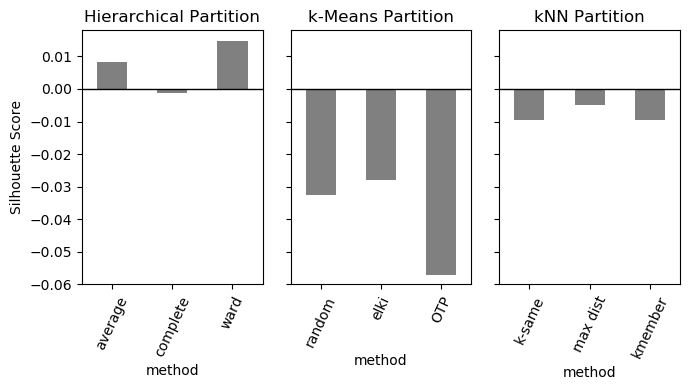

In [11]:
# Draw bar-plot for mean Silhouette

df_extract1 = df_final[['mean silhouette', 'method', 'strategy']]
df_extract1 = df_extract1.drop_duplicates()
print(df_extract1)
# u = df_extract.strategy.unique()
u = ['hierarchical partition','k-means variance', 'knn variance']
print(u)
fig, axes = plt.subplots(ncols=len(u), figsize=(7,4))
plt.style.use('default')
titles = ['Hierarchical Partition', 'k-Means Partition', 'kNN Partition']
for strategy, ax, title in zip(u, axes, titles):
    df_extract1[df_extract1.strategy==strategy].plot.bar(x="method", title=title, color = 'gray', ax =ax ,sharey=True)
    ax.set_ylim([-0.06, 0.018])
    ax.tick_params(axis='x', rotation=65)
#     ax.grid(linestyle='-.', linewidth=0.5, alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', linewidth = 1)
    ax.legend().set_visible(False)
    ax.set_ylabel('Silhouette Score')
plt.tight_layout()  
# plt.savefig('clustering_sil.pdf',dpi=300, bbox_inches = "tight")
plt.show()

[Improvement Space] A new version of HP

This is faster version of Hierarchical Partitioning. This is 1000 times faster. The idea is to calculate the linkage matrix one, then do tree manipulations, no extra re-calcualation of the tree is needed. Currently, there is one problem is that we only have lower bound for the cluster size, no upper bound or fixed size dictation. 

In [14]:
import time
start_time = time.time()
cluster = partitioning.hp_v2(data,k=4)
print('Finished in: ', time.time()-start_time )

Finished in:  0.25191473960876465


This is the cluster size after clustering (or partitioning). We see that even though no upper-bound is given, the cluster size ranging from 4-6. And two outliers!!! Need to investigate these ones.